## HW 6 JG6615 Due 4/22/22

## Decision Tree Implementation

In this problem we’ll implement decision trees for both classification and regression. The strategy will be to implement a generic class, called Decision Tree, which we’ll supply with the loss function we want to use to make node splitting decisions, as well as the estimator we’ll use to come up with the prediction associated with each leaf node. 

For classification, this prediction could be a vector of probabilities, but for simplicity we’ll just consider hard classifications here. We’ll work with the classification and regression data sets from previous assignments.

# Problem 1:
Complete the compute_entropy and compute_gini functions

## Problem 1 Answer:
Done Below

In [1]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier
import graphviz

from IPython.display import Image

%matplotlib inline

### Load Data

data_train = np.loadtxt('codes_and_data/svm-train.txt')
data_test = np.loadtxt('codes_and_data/svm-test.txt')
x_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)
# Change target to 0-1 label
y_train_label = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train))).reshape(-1, 1)

## Entropy Definition for binary labels:

$$-\sum_{i=0}^1 P(Class_i)*log_2(P(Class_i))$$

## Gini definition for Binary Labels
$$\sum_{i=0}^1 P(Class_i)(1-P(Class_i))$$



In [2]:
def compute_entropy(label_array):
    '''
    Calulate the entropy of given label list
    :param label_array: a numpy array of binary labels shape = (n, 1)
    :return entropy: entropy value
    '''
    """
    """
    #transform array into pd.Series to access value_counts method
    unique = np.unique(label_array)[0]
    p = len(label_array[label_array == unique])/len(label_array)
    if p == 0 or p ==1:
        return(0)
    else:
        val = p*np.log2(p)+(1-p)*np.log2(1-p)
        return(-1*val)

def compute_gini(label_array):
    '''
    Calulate the gini index of label list
    :param label_array: a numpy array of labels shape = (n, 1)
    :return gini: gini index value
    '''
    #transform array into pd.Series to access value_counts method
    #transform array into pd.Series to access value_counts method
    unique = np.unique(lael_array)[0]
    p = len(label_array[label_array == unique])/len(label_array)
    if p == 0 or p ==1:
        return(0)
    else:
        return(1- p**2 - (1-p)**2)

# Problem 2: 

Complete the class Decision Tree, given in the skeleton code. 

The intended implementation is as follows: Each object of type Decision Tree represents a single node of the tree.

The depth of that node is represented by the variable self.depth, with the root node having depth 0. 

The main job of the fit function is to decide, given the data provided, how to split the node or whether it should remain a leaf node. If the node will split, then the splitting feature and splitting value are recorded, and the left and right subtrees are fit on the relevant portions of the data. Thus tree-building is a recursive procedure.

We should have as many Decision Tree objects as there are nodes in the tree. We will not implement pruning here. Some additional details are given in the skeleton code.

## Problem 2  Answer:

Done Below 

In [3]:
class Decision_Tree(BaseEstimator):
     
    def __init__(self, split_loss_function, leaf_value_estimator,
                 depth=0, min_sample=5, max_depth=10):
        '''
        Initialize the decision tree classifier

        :param split_loss_function: method with args (X, y) returning loss
        :param leaf_value_estimator: method for estimating leaf value from array of ys
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        '''
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth
        self.is_leaf = False

    def fit(self, x, y):
        '''
        This should fit the tree classifier by setting the values self.is_leaf, 
        self.split_id (the index of the feature we want ot split on, if we're splitting),
        self.split_value (the corresponding value of that feature where the split is),
        and self.value, which is the prediction value if the tree is a leaf node.  If we are 
        splitting the node.
        
        we should also init self.left and self.right to be Decision_Tree
        objects corresponding to the left and right subtrees. These subtrees should be fit on
        the data that fall to the left and right,respectively, of self.split_value.
        This is a recurisive tree building procedure. 
        
        :param X: a numpy array of training data, shape = (n, m)
        :param y: a numpy array of labels, shape = (n, 1)

        :return self
        '''
        
       
        initial_split =10e10
        #recursive stopping criteria, stop if beyond max depth or not enough
        #points to split a leaf further 
        if self.depth >= self.max_depth or len(y) <= self.min_sample:
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)

            return self
        
        #calculate the best feature to split on,
        self.find_best_feature_split(x,y)


        #if this split value is better than the initialized split value above
        if self.split_value <= initial_split:
            #create right decision tree
            self.right = Decision_Tree(self.split_loss_function,
                                     self.leaf_value_estimator, self.depth+1,
                                     self.min_sample, self.max_depth)
            
            #create left decision tree
            
            self.left = Decision_Tree(self.split_loss_function,
                                     self.leaf_value_estimator, self.depth+1,
                                     self.min_sample, self.max_depth)
            
            #create a new dataset, so i can easily subset based on split value
            data = np.append(x,y,axis=1)
            
            #subset left x_data to those below split value
            x_l = data[data[:,self.split_id] <= self.split_value]
            #remove the last column, which corresponds to my labels 
            #that i added to data
            x_l = x_l[:,:-1]
            
            #subset left y data using same logic, only selecting last column
            y_l = data[data[:,self.split_id] <= self.split_value]
            y_l = y_l[:,-1].reshape((len(y_l),1)) #reshape otherwise numpy yells at me 
            
            #duplicate on the right side
            x_r = data[data[:,self.split_id] > self.split_value]
            x_r = x_r[:,:-1]
            y_r = data[data[:,self.split_id] > self.split_value]
            y_r = y_r[:,-1].reshape((len(y_r),1))
            
            #recursively attempt same process on left and right trees
            self.left.fit(x_l,y_l)
            self.right.fit(x_r,y_r)
            
        #if my initial splitting value is fine, we set the input of the 
        #.fit() function to be a leaf and get the predicted value of the region
        else: 
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
        
        
        
        return self

    def find_best_split(self, x_node, y_node, feature_id):
        '''
        For feature number feature_id, returns the optimal splitting point 
        for data X_node, y_node, and corresponding loss
        :param X: a numpy array of training data, shape = (n_node,m)
        :param y: a numpy array of labels, shape = (n_node, 1)
        '''
        #subset the data based on specific feature and reshape such that this nx1 is actually an nx1
        x_node = x_node[:,feature_id].reshape((x_node.shape[0],1))

        n = len(x_node)
        
        #create a dataset that has both x and y 
        data = np.append(x_node,y_node,axis=1)
        
        #sort dataset to find splitting points
        #https://stackoverflow.com/questions/2828059/sorting-arrays-in-numpy-by-column
        
        data = data[data[:, 0].argsort()]
        
        #calculate base loss to compare future losses from splits
        split_value   = np.min(x_node)-1 #create a split that takes all of the data
        best_loss = self.split_loss_function(y_node)
        
        
        #create a set of values to split on 
        unique_x = np.unique(x_node)
        
        #iterate through all unique split points, choosing the mid points
        for i in range(len(unique_x)-1):
            temp_split_val = (unique_x[i]+unique_x[i+1])/2
            
            #subset data left and data right by using the selected split value
            dl = data[data[:,0] <= temp_split_val]
            dr = data[data[:,0] > temp_split_val]
            
            #calculate entropy for left and right datasets
            loss_dl = self.split_loss_function(dl[:,1])
            loss_dr = self.split_loss_function(dr[:,1])
            
            #scale by number of data points in the region
            temp_loss = loss_dl*(len(dl)/n)+loss_dr*(len(dr)/n)
            
            #reassign loss and split value if this split is better
            #than the previous best split value
            if temp_loss <= best_loss:
                split_value = temp_split_val
                best_loss = temp_loss 
                
        return(split_value, best_loss)



    def find_best_feature_split(self, x_node, y_node):
        '''
        Returns the optimal feature to split and best splitting point 
        for data X_node, y_node.
        :param X: a numpy array of training data, shape = (n_node, 1)
        :param y: a numpy array of labels, shape = (n_node, 1)
        '''
        #iterate over all columns, adding the best split and column index to dicts
        sv_dict = {}
        loss_dict = {}
        for i in range(x_node.shape[1]):
            sv_dict[i], loss_dict[i], = self.find_best_split(x_node,y_node, i)[0],self.find_best_split(x_node,y_node, i)[1]
        #https://stackoverflow.com/questions/3282823/get-the-key-corresponding-to-the-minimum-value-within-a-dictionary
        
        #chose the colun index that has minimum entropy
        self.split_id = min(loss_dict, key=loss_dict.get)
        
        #chose the value for respective column that results in minimum entropy
        self.split_value = sv_dict[self.split_id]
        
        #record loss value for debugging
        self.loss = loss_dict[self.split_id]
        

    def predict_instance(self, instance):
        '''
        Predict label by decision tree

        :param instance: a numpy array with new data, shape (1, m)

        :return whatever is returned by leaf_value_estimator for leaf containing instance
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)

In [4]:
class Classification_Tree(BaseEstimator, ClassifierMixin):

    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }

    def __init__(self, loss_function='entropy', min_sample=5, max_depth=10):
        '''
        :param loss_function(str): loss function for splitting internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                most_common_label,
                                0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Problem 3:

Run the code provided that builds trees for the two-dimensional classification data. Include the results. For debugging, you may want to compare results with sklearn’s decision tree (code provided in the skeleton code). For visualization, you’ll need to install graphviz.

## Problem 3 Answer:

Done below 

In [5]:
def most_common_label(y):
    '''
    Find most common label
    '''
    label_cnt = Counter(y.reshape(len(y)))
    label = label_cnt.most_common(1)[0][0]
    return label

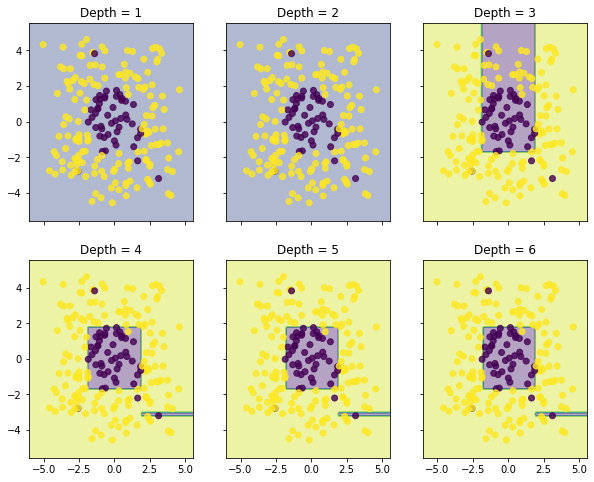

In [6]:
#Training classifiers with different depth
clf1 = Classification_Tree(max_depth=1, min_sample=2)
clf1.fit(x_train, y_train_label)

clf2 = Classification_Tree(max_depth=2, min_sample=2)
clf2.fit(x_train, y_train_label)

clf3 = Classification_Tree(max_depth=3, min_sample=2)
clf3.fit(x_train, y_train_label)

clf4 = Classification_Tree(max_depth=4, min_sample=2)
clf4.fit(x_train, y_train_label)

clf5 = Classification_Tree(max_depth=5, min_sample=2)
clf5.fit(x_train, y_train_label)

clf6 = Classification_Tree(max_depth=6, min_sample=2)
clf6.fit(x_train, y_train_label)

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],                    
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label[:,0], alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

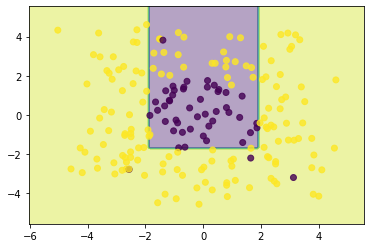

In [7]:
#comparing with sK learn 
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=2)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file='tree_classifier.dot')

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = np.array([clf.predict(x[np.newaxis,:]) for x in np.c_[xx.ravel(), yy.ravel()]])
Z = Z.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(x_train[:, 0], x_train[:, 1], 
c=y_train_label[:,0], alpha=0.8)

# Problem 4: 

Complete the function mean absolute deviation around median (MAE). Use the code provided to fit the Regression Tree to the krr dataset using both the MAE loss and median predictions. Include the plots for the 6 fits.

## Problem 4 Answer:

Done below

In [8]:
def mean_absolute_deviation_around_median(y):
    '''
    Calulate the mean absolute deviation around the median of a given target list
    
    :param y: a numpy array of targets shape = (n, 1)
    :return mae
    '''

    median, n = np.median(y), len(y)
    abs_deviation = 0
    for i in range(len(y)):
        abs_deviation += abs(y[i]-median)
    return(abs_deviation)

In [9]:
class Regression_Tree():
    '''
    :attribute loss_function_dict: dictionary containing the loss functions used for splitting
    :attribute estimator_dict: dictionary containing the estimation functions used in leaf nodes
    '''

    loss_function_dict = {
        'mse': np.var,
        'mae': mean_absolute_deviation_around_median
    }

    estimator_dict = {
        'mean': np.mean,
        'median': np.median
    }
    
    def __init__(self, loss_function='mse', estimator='mean', min_sample=5, max_depth=10):
        '''
        Initialize Regression_Tree
        :param loss_function(str): loss function used for splitting internal nodes
        :param estimator(str): value estimator of internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                  self.estimator_dict[estimator],
                                  0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

<div style="page-break-after: always;"></div>

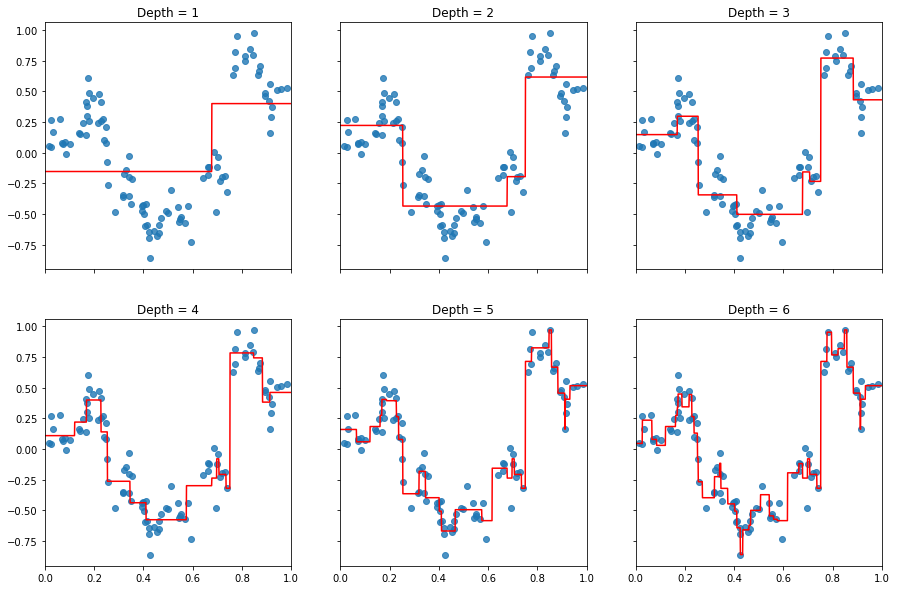

In [10]:
data_krr_train = np.loadtxt('codes_and_data/krr-train.txt')
data_krr_test = np.loadtxt('codes_and_data/krr-test.txt')
x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1),data_krr_train[:,1].reshape(-1,1)
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1),data_krr_test[:,1].reshape(-1,1)

# Training regression trees with different depth
clf1 = Regression_Tree(max_depth=1,  min_sample=3, loss_function='mae', estimator='mean')
clf1.fit(x_krr_train, y_krr_train)

clf2 = Regression_Tree(max_depth=2,  min_sample=3, loss_function='mae', estimator='mean')
clf2.fit(x_krr_train, y_krr_train)

clf3 = Regression_Tree(max_depth=3,  min_sample=3, loss_function='mae', estimator='mean')
clf3.fit(x_krr_train, y_krr_train)

clf4 = Regression_Tree(max_depth=4,  min_sample=3, loss_function='mae', estimator='mean')
clf4.fit(x_krr_train, y_krr_train)

clf5 = Regression_Tree(max_depth=5,  min_sample=3, loss_function='mae', estimator='mean')
clf5.fit(x_krr_train, y_krr_train)

clf6 = Regression_Tree(max_depth=10,  min_sample=3, loss_function='mae', estimator='mean')
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.show()

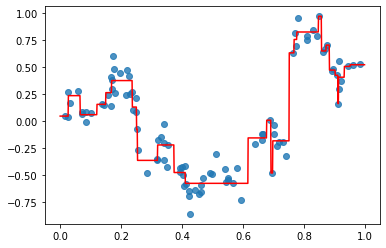

In [11]:
#compare with sklearn
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)
x_range.shape

clf = DecisionTreeRegressor(criterion="squared_error", max_depth=5, min_samples_split=3)
clf.fit(x_krr_train, y_krr_train)
y_range = clf.predict(x_range)
plt.scatter(x_krr_train, y_krr_train, alpha=0.8)
plt.plot(x_range,y_range, color='r')



## Ensembling 

Recall the general gradient boosting algorithm, for a given loss function $\ell$ and a hypothesis space $\mathcal{F}$ of regression functions (i.e. functions mapping from the input space to $\mathcal{R}$): 

0. Initialize $f_0(x)$ = 0
1. For m = 1 to M:
        a. compute:
        
$$g_{m} = \frac{\delta}{\delta f_{m-1}(x_j)}\sum_i^nl(y_i,f_{m-1}(x_i)){_{j=1}^n}$$

        b. Fit regression model to gm:
        
$$h_m = \underset{h \in \mathcal{F}}{argmin} \sum_i^n((-g_m)_i - h(x_i))^2 $$

        c. Choose fixed step size v in (0,1] or take:
        
$$v_m = \underset{v > 0}{argmin} \sum_i^nl(y_i,f_{m-1}(x_i)+vh_m(x_i)) $$

        d. take the step:
        
$$ f_m(x) = f_{m-1}(x) + v_mh_m(x) $$

2. Return $f_M$

This method goes by many names, including gradient boosting machines (GBM), generalized boosting models (GBM), AnyBoost, and gradient boosted regression trees (GBRT), among oth- ers. One of the nice aspects of gradient boosting is that it can be applied to any problem with a subdifferentiable loss function.


## Gradient boosting Regression Implementation 

First we’ll keep things simple and consider the standard regression setting with square loss. In this case the we have Y = R, our loss function is given by l(yˆ, y) = $1/2 (yˆ − y)^2$, and at the m’th round of gradient boosting, we have:

$$ h_{m}=\underset{h \in \mathcal{F}}{argmin}\sum_{i=1}^{n}[(y_{i}-f_{m-1}(x_{i}))-h(x_{i})]^{2}.$$

# Problem 5:

Complete the gradient boosting class. As the base regression algorithm to compute the argmin, you should use sklearn’s regression tree. You should use the square loss for the tree splitting rule (criterion keyword argument) and use the default sklearn leaf prediction rule from the predict method. We will also use a constant step size v.

## Problem 5 Answer:

Done below



In [12]:
#Pseudo-residual function.

def pseudo_residual_L2(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    return train_target - train_predict

class gradient_boosting():
    '''
    Gradient Boosting regressor class
    :method fit: fitting model
    '''
    def __init__(self, n_estimator, pseudo_residual_func, learning_rate=0.01, 
                 min_sample=5, max_depth=5):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual between training labels and predicted labels at each iteration
        :param learning_rate: step size of gradient descent
        '''
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth

        self.estimators = [] #will collect the n_estimator models
    
   
    def fit(self, train_data, train_target):
        '''
        Fit gradient boosting model
        :train_data array of inputs of size (n_samples, m_features) 
        :train_target array of outputs of size (n_samples,) 
        '''
        # Your code goes here 
        #we will create n_estimators so iterate through that range
        resid_list = []
        for i in range(self.n_estimator):
            #initialize f_0 = 0
            if i == 0:
                func = np.zeros(len(train_target))
                self.estimators.append(func)
            elif i == 1:
                #first iteration, we fit a regression tree onto the training target
                h = DecisionTreeRegressor(min_samples_split=self.min_sample,max_depth=self.max_depth)
                h.fit(train_data, train_target.flatten())
                self.estimators.append(h)
            else:
                #second time, we recurisvely call our predict function to 
                #see the cumulative prediction for our training data
                y_hat = self.predict(train_data)
                #calculate residuals after getting most recent predictions
                pseudo_res = train_target.flatten()-y_hat
                
                #fit decision tree on new residuals 
                h = DecisionTreeRegressor(min_samples_split=self.min_sample,max_depth=self.max_depth)
                h.fit(train_data, pseudo_res)
                self.estimators.append(h)
        return(self)




           
    
    def predict(self, test_data):
        '''
        Predict value
        :train_data array of inputs of size (n_samples, m_features)
        '''
        # Your code goes here
        for i in range(0,len(self.estimators)):
            if i == 0:
                test_predict = np.zeros(len(test_data))
            else:
                test_predict += self.learning_rate * self.estimators[i].predict(test_data)
        return test_predict



# Problem 6:

Run the code provided to build gradient boosting models on the regression data sets krr-train.txt, and include the plots generated. For debugging you can use the sklearn implementation of GradientBoostingRegressor

## Problem 6 Answer:

Done below

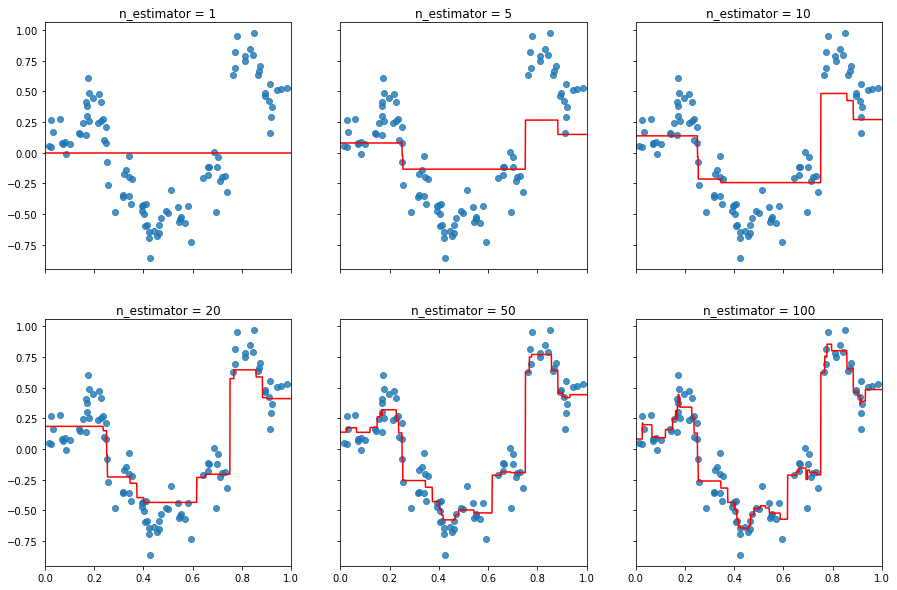

In [13]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]
                       ]):
    
    gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, 
                               max_depth=2, learning_rate=0.1)  
    gbm_1d.fit(x_krr_train, y_krr_train[:,0])
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)

<div style="page-break-after: always;"></div>

## Classification of images with Gradient Boosting

In this problem we will consider the classification of MNIST, the dataset of handwritten digits images, with ensembles of trees. For simplicity, we only retain the ‘0’ and ’1’ examples and perform binary classification.

First we’ll derive a special case of the general gradient boosting framework: BinomialBoost. Let’s consider the classification framework, where Y = {−1, 1}. 

In lecture, we noted that AdaBoost corresponds to forward stagewise additive modeling with the exponential loss, and that the exponential loss is not very robust to outliers (i.e. outliers can have a large effect on the final prediction function). Instead, let’s consider the logistic loss

$$l(m) = ln(1+e^{-m})$$

where m = yf(x) is the margin

# Problem 7:
Give the expression of the negative gradient step direction, or pseudo residual, −$g_m$ for the logistic loss as a function of the prediction function $f_{m-1}$ at the previous iteration and the dataset points ${(x_i,y_i)}{_{i=1}^n}$. 

What is the dimension of $g_m$?

## Problem 7 answer:

Done below


# Problem 8:

Write an expression for $h_m$ as an argmin over functions h in $\mathcal{F}$

## Problem 8 answer:

Done below

# Problem 9:

Load the MNIST dataset using the helper preprocessing function in the skeleton code.Using the scikit learn implementation of GradientBoostingClassifier, with the logistic loss (loss=‘deviance’) and trees of maximum depth 3, fit the data with 2, 5, 10, 100 and 200 iterations (estimators). Plot the train and test accuracy as a function of the number of estimators.

## Problem 9 answer:

Done below 


<div style="page-break-after: always;"></div>

## Classification with Random Forests (Optional)

# Problem 10:

Another type of ensembling method we discussed in class are random forests. Explain in your own words the construction principle of random forests.

## Problem 10 Answer:

A random forest is an ensembling of decision trees for either regression or classification. 

The random forest are constructed as follows:

1. In a parallel process, many permutations of our data are created through bootstrapping.

2. For each of these boot-strapped samples takes a subset of features in our training data, (usually sqrt(num_features) or log(num_features). By both bootstrapping and taking a random subset of features, we make sure each individual decision tree has some variability between them.

3. Individual decision trees are built (again, in parallel) by trying to maximize information gain. Best practice suggests that these trees should not be too deep, to avoid over-fitting.

4. The n_trees parameter determines how many individual decision trees are to be built, once all of the trees have been finalized by maximizing information gain, and reaching the maximum depth the random forest can make a prediction on a new data point by ensembling each individual tree's prediction for that data point.

There are many ways the ensembling can take place, either through some type of weighted averaging of the individual decision trees, or in the case of classification, the class that has the most decision trees chose it will be the predicted output for a given sample.



# Problem 11:

Using the scikit learn implementation of RandomForestClassifier, with the entropy loss (criterion=‘entropy’) and trees of maximum depth 3, fit the preprocessed binary MNIST dataset with 2, 5, 10, 50, 100 and 200 estimators

## Problem 11 Answer:

Done below



# Problem 12

What general remark can you make on overfitting for Random Forests and Gradient Boosted Trees? Which method achieves the best train accuracy overall? Is this result expected? Can you think of a practical disadvantage of the best performing method? How do the algorithms compare in term of test accuracy?

## Problem 12 Answer: